### Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Lambda
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

tf.keras.backend.set_floatx('float32')

### Load the data

In [2]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [3]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [4]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [5]:
df.isnull().values.any()

False

In [6]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [7]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(1000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [8]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [9]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train, X_train_f = X_train[X_train.Class == 0], X_train[X_train.Class == 1]
X_train, X_train_f = X_train.drop(['Class'], axis=1), X_train_f.drop(['Class'], axis=1)
X_train = X_train.values

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [17]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

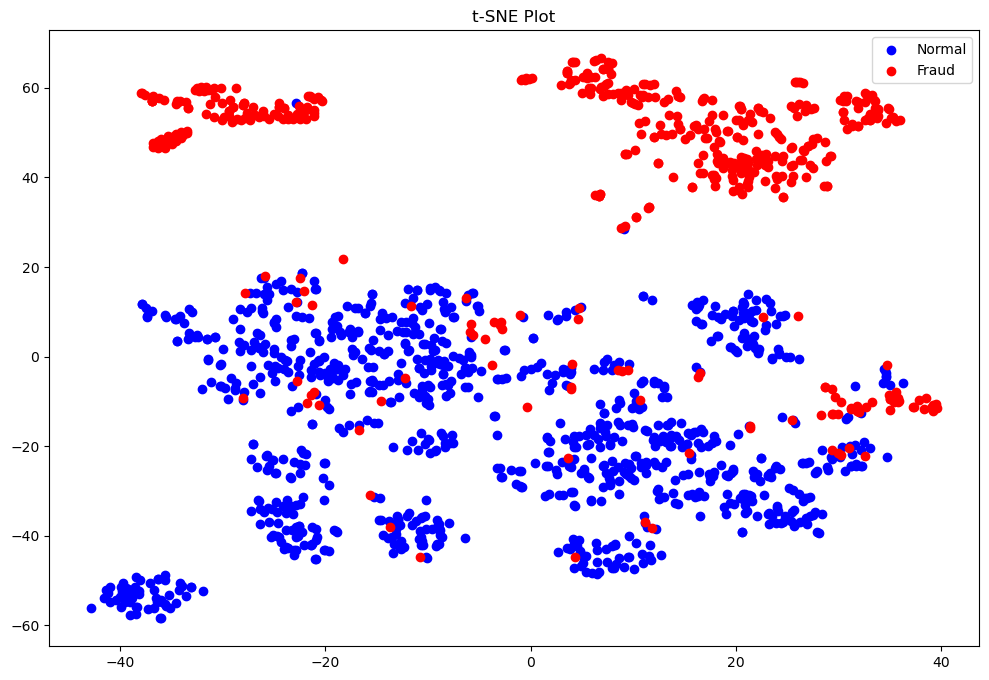

In [18]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

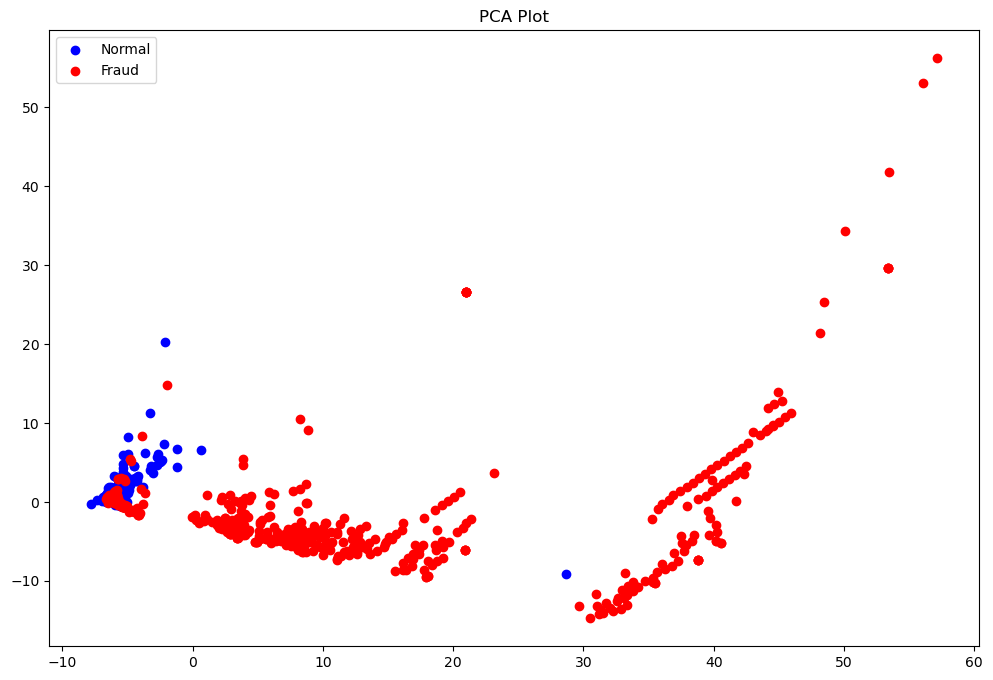

In [21]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);
scaler.transform(X_train_f);

### Variation AutoEncoder Model

In [11]:
def sampling(inputs):
    z_mean, z_log_var = inputs
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

latent_dim = 7;

In [12]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(14, activation="relu")(input_layer)

z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

hid_decoder = Dense(14, activation='relu')(z)
decoded_mean = Dense(input_dim)(hid_decoder)

vae = Model(inputs=input_layer, outputs=decoded_mean)

vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 14)                   406       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 7)                    105       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 7)                    105       ['dense[0][0]']               
                                                                                              

In [13]:
# def vae_loss(x, decoded_mean):
#     rec_loss = K.sum(K.square(x - decoded_mean), axis=-1)
#     kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return K.mean((rec_loss + kl_loss) / 2)

rec_loss = 28 * metrics.mean_squared_error(input_layer, decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + kl_loss)

In [14]:
epochs = 100
batch_size = 32

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
checkpointer = ModelCheckpoint(filepath="fraudVAE.pth", verbose=0, save_best_only=True)

### Training

In [15]:
history = vae.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5580/5598 [============================>.] - ETA: 0s - loss: 24.7412INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 24.7297 - val_loss: 20.7688
Epoch 2/100
5588/5598 [============================>.] - ETA: 0s - loss: 19.9884INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 19.9829 - val_loss: 18.8457
Epoch 3/100
5586/5598 [============================>.] - ETA: 0s - loss: 18.4667INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 18.4645 - val_loss: 17.9729
Epoch 4/100
5593/5598 [============================>.] - ETA: 0s - loss: 17.8185INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 17.8182 - val_loss: 17.6058
Epoch 5/100
5591/5598 [============================>.] - ETA: 0s - loss: 17.4716INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 17.4681 - val_loss: 17.2786
Epoch 6/100
5589/5598 [============================>.] - ETA: 0s - loss: 17.2767INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 17.2758 - val_loss: 17.2105
Epoch 7/100
5595/5598 [============================>.] - ETA: 0s - loss: 17.2034INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 17.2036 - val_loss: 17.1520
Epoch 8/100
5598/5598 [==============================] - 12s 2ms/step - loss: 17.1644 - val_loss: 17.1750
Epoch 9/100
5579/5598 [============================>.] - ETA: 0s - loss: 17.1191INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 17.1159 - val_loss: 17.1315
Epoch 10/100
5594/5598 [============================>.] - ETA: 0s - loss: 17.0794INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 17.0785 - val_loss: 17.0660
Epoch 11/100
5593/5598 [============================>.] - ETA: 0s - loss: 17.0318INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 17.0331 - val_loss: 17.0503
Epoch 12/100
5580/5598 [============================>.] - ETA: 0s - loss: 17.0177INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 17.0156 - val_loss: 16.9929
Epoch 13/100
5582/5598 [============================>.] - ETA: 0s - loss: 16.9784INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 16.9787 - val_loss: 16.9440
Epoch 14/100
5595/5598 [============================>.] - ETA: 0s - loss: 16.9452INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 16.9439 - val_loss: 16.9283
Epoch 15/100
5592/5598 [============================>.] - ETA: 0s - loss: 16.9071INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 16.9053 - val_loss: 16.8691
Epoch 16/100
5598/5598 [==============================] - 14s 2ms/step - loss: 16.8911 - val_loss: 16.8748
Epoch 17/100
5583/5598 [============================>.] - ETA: 0s - loss: 16.8785INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 16.8777 - val_loss: 16.8495
Epoch 18/100
5575/5598 [============================>.] - ETA: 0s - loss: 16.8444INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 16.8435 - val_loss: 16.8245
Epoch 19/100
5598/5598 [==============================] - 16s 3ms/step - loss: 16.8479 - val_loss: 16.8447
Epoch 20/100
5597/5598 [============================>.] - ETA: 0s - loss: 16.8497INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 16.8498 - val_loss: 16.8014
Epoch 21/100
5598/5598 [==============================] - 14s 2ms/step - loss: 16.8176 - val_loss: 16.8330
Epoch 22/100
5598/5598 [==============================] - 14s 2ms/step - loss: 16.8091 - val_loss: 16.9780
Epoch 23/100
5598/5598 [==============================] - 15s 3ms/step - loss: 16.8008 - val_loss: 16.8574
Epoch 24/100
5575/5598 [============================>.] - ETA: 0s - loss: 16.7579INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 16.7563 - val_loss: 16.7244
Epoch 25/100
5594/5598 [============================>.] - ETA: 0s - loss: 16.7469INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 16.7461 - val_loss: 16.7171
Epoch 26/100
5598/5598 [==============================] - 15s 3ms/step - loss: 16.7210 - val_loss: 16.7408
Epoch 27/100
5595/5598 [============================>.] - ETA: 0s - loss: 16.6971INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 16.6982 - val_loss: 16.7082
Epoch 28/100
5598/5598 [==============================] - 12s 2ms/step - loss: 16.6959 - val_loss: 16.7356
Epoch 29/100
5589/5598 [============================>.] - ETA: 0s - loss: 16.6771INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 16.6763 - val_loss: 16.6946
Epoch 30/100
5593/5598 [============================>.] - ETA: 0s - loss: 16.6874INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 16.6871 - val_loss: 16.6659
Epoch 31/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6851 - val_loss: 16.6943
Epoch 32/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6620 - val_loss: 16.6990
Epoch 33/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6658 - val_loss: 16.6786
Epoch 34/100
5585/5598 [============================>.] - ETA: 0s - loss: 16.6870INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 16.6875 - val_loss: 16.6530
Epoch 35/100
5598/5598 [==============================] - 16s 3ms/step - loss: 16.6596 - val_loss: 16.6918
Epoch 36/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6649 - val_loss: 16.6866
Epoch 37/100
5576/5598 [============================>.] - ETA: 0s - loss: 16.6637INFO:tensorflow:Assets written to: fraudVAE.pth\assets


INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 16.6615 - val_loss: 16.6311
Epoch 38/100
5598/5598 [==============================] - 12s 2ms/step - loss: 16.6875 - val_loss: 16.6436
Epoch 39/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6606 - val_loss: 16.6503
Epoch 40/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6690 - val_loss: 16.7017
Epoch 41/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6893 - val_loss: 16.6535
Epoch 42/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6559 - val_loss: 16.6338
Epoch 43/100
5598/5598 [==============================] - 12s 2ms/step - loss: 16.6635 - val_loss: 16.7057
Epoch 44/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6574 - val_loss: 16.6605
Epoch 45/100
5598/5598 [==============================] - 14s 3ms/step - loss: 16.6582 - val_loss: 16.6446
Epoch 46/100
5598/5598 [==========================

INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 16.6414 - val_loss: 16.6007
Epoch 59/100
5598/5598 [==============================] - 12s 2ms/step - loss: 16.6559 - val_loss: 16.6806
Epoch 60/100
5598/5598 [==============================] - 12s 2ms/step - loss: 16.6325 - val_loss: 16.6057
Epoch 61/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6459 - val_loss: 16.6387
Epoch 62/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6640 - val_loss: 16.7116
Epoch 63/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6436 - val_loss: 16.6649
Epoch 64/100
5598/5598 [==============================] - 16s 3ms/step - loss: 16.6478 - val_loss: 16.6306
Epoch 65/100
5598/5598 [==============================] - 15s 3ms/step - loss: 16.6468 - val_loss: 16.6713
Epoch 66/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6494 - val_loss: 16.6672
Epoch 67/100
5598/5598 [==========================

INFO:tensorflow:Assets written to: fraudVAE.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 16.6348 - val_loss: 16.5995
Epoch 83/100
5598/5598 [==============================] - 13s 2ms/step - loss: 16.6492 - val_loss: 16.6732
Epoch 84/100
5598/5598 [==============================] - 12s 2ms/step - loss: 16.6397 - val_loss: 16.7426
Epoch 85/100
5598/5598 [==============================] - 12s 2ms/step - loss: 16.6346 - val_loss: 16.6424
Epoch 86/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6320 - val_loss: 16.6203
Epoch 87/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6525 - val_loss: 16.6422
Epoch 88/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6271 - val_loss: 16.6776
Epoch 89/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6306 - val_loss: 16.6570
Epoch 90/100
5598/5598 [==============================] - 11s 2ms/step - loss: 16.6211 - val_loss: 16.6496
Epoch 91/100
5598/5598 [==========================

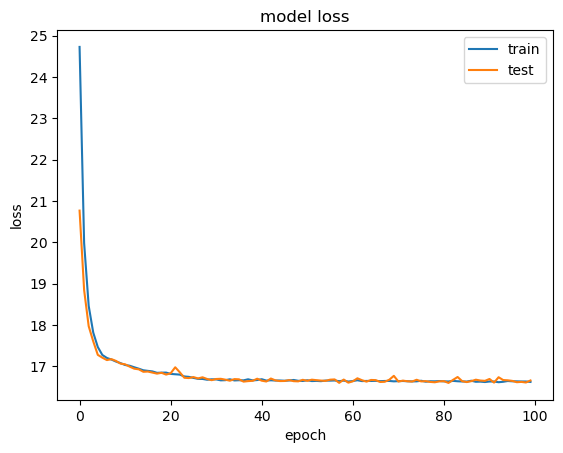

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [17]:
#vae = load_model('fraudVAE.pth') 
# ISSUE: fail to load model using lambda layer  // ref (NameError: Exception encountered when calling layer "lambda"0

In [18]:
predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 4s 1ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.452781,0.00165
std,1.451049,0.04059
min,0.030951,0.00000
25%,0.231820,0.00000
50%,0.327128,0.00000
75%,0.499623,0.00000
max,73.997036,1.00000


In [19]:
threshold = 2.9

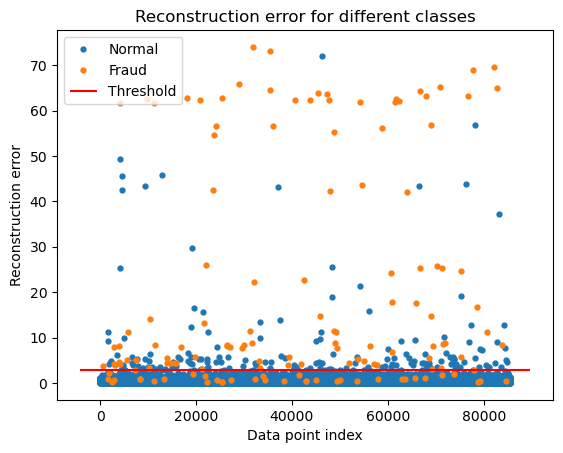

In [20]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

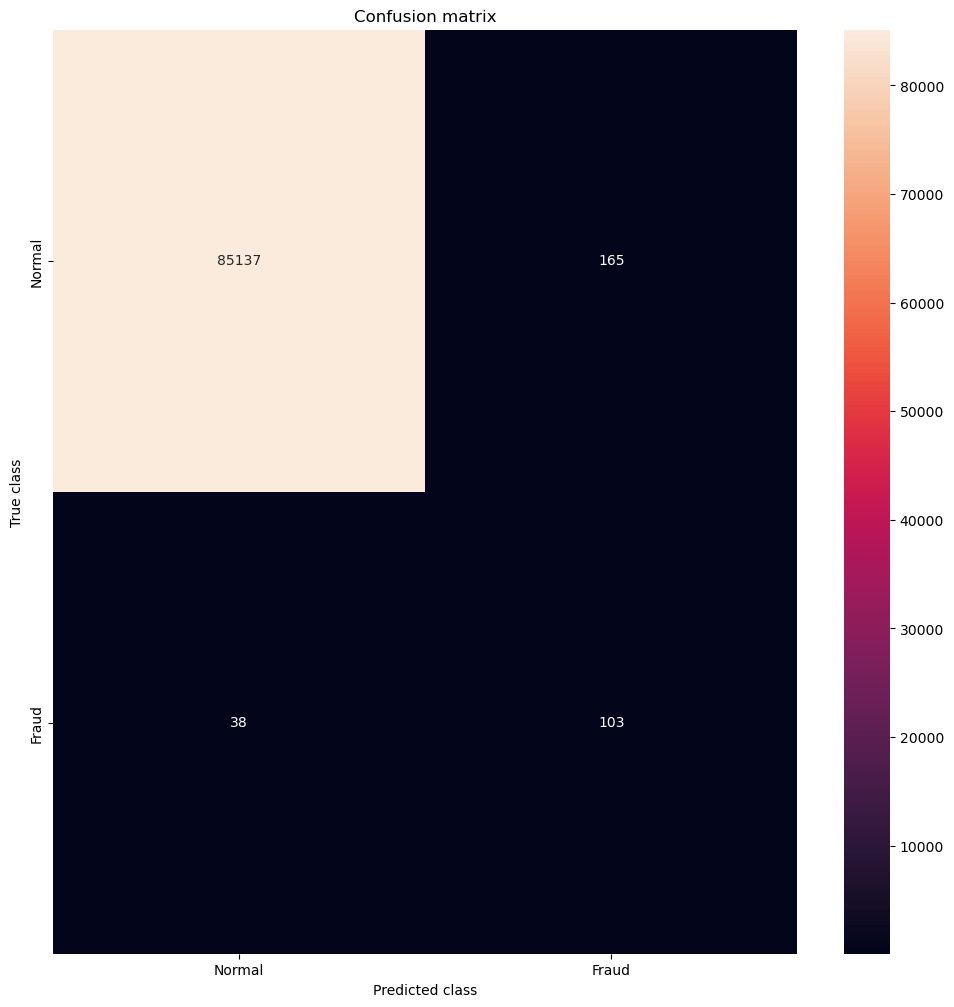

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [22]:
inp_layer = vae.input
out_layer = vae.layers[4].output

encoder = Model(inputs=inp_layer, outputs=out_layer)

In [23]:
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 14)                   406       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 7)                    105       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 7)                    105       ['dense[0][0]']               
                                                                                            

2671/2671 [==============================] - 4s 1ms/step


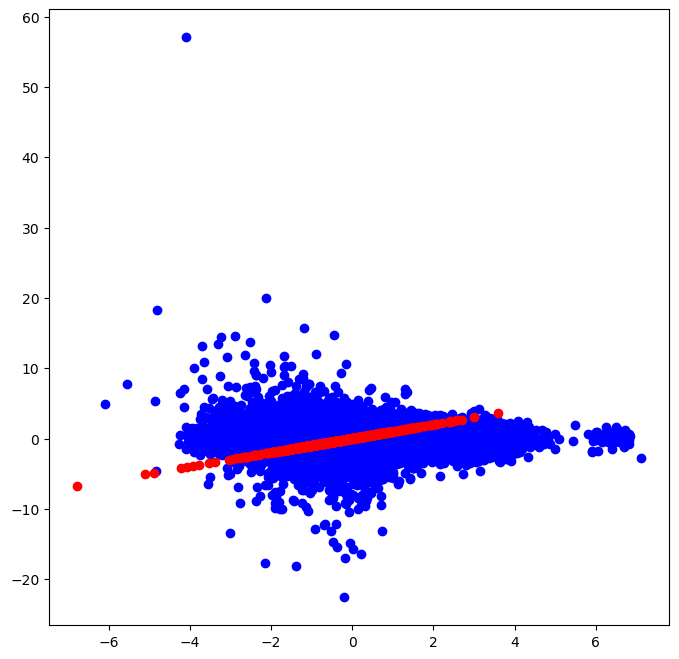

In [26]:
X_train_encoded = encoder.predict(X_train)
X_train_f_encoded = encoder.predict(X_train_f)
X_test_encoded = encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
X_encoded = np.vstack((X_encoded, X_train_f_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))
y_main = np.hstack((y_main, np.ones(len(X_train_f_encoded))))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[7]==0][0],encoded_df[encoded_df[7]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[7]==1][1],encoded_df[encoded_df[7]==1][1], color='red', label='Fraud');

### Generate Fraud data

In [27]:
fraud_encodings = encoder.predict(X_train_f,batch_size=128)

3/3 [==============================] - 0s 3ms/step


In [28]:
fraud_encodings.shape

(351, 7)

In [31]:
inp_layer = Input(shape=(latent_dim,))
h_decoded = vae.layers[5](inp_layer)
x_decoded_mean = vae.layers[6](h_decoded)

generator = Model(inputs=inp_layer, outputs=x_decoded_mean )

generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_3 (Dense)             (None, 14)                112       
                                                                 
 dense_4 (Dense)             (None, 28)                420       
                                                                 
Total params: 532 (2.08 KB)
Trainable params: 532 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
more_frauds = generator.predict(fraud_encodings)

11/11 [==============================] - 0s 2ms/step


In [53]:
x3 = more_frauds

genClass = np.full((x3.shape[0], 1), 2)
x3 = np.hstack((x3, genClass))

x3 = pd.DataFrame(x3)

x3.columns = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
              'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
              'V21','V22','V23','V24','V25','V26','V27','V28','Class']

In [54]:
x3

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-2.581928,2.704674,-3.330681,-0.367649,-0.251604,-1.336160,-0.372700,1.532759,-0.072532,-1.342818,...,-0.178790,0.149397,-0.003829,-0.084779,-0.122519,0.064003,0.038014,-0.111928,-0.031978,2.0
1,-3.731385,1.248842,-2.943464,1.450462,0.976391,-1.205422,-1.132689,0.247417,-0.431154,-0.597348,...,-1.886240,-0.899697,0.376252,-0.089358,-0.091137,0.133788,-0.020744,0.028054,0.022995,2.0
2,-11.368033,4.041985,-11.594732,1.226524,-1.979849,0.991889,-6.693286,8.321036,-2.774864,-0.815930,...,-0.398868,0.791185,-0.819754,-0.026452,0.295966,0.293447,-0.094465,-0.467262,-0.328767,2.0
3,-0.726672,1.290514,1.225336,2.757220,0.645075,0.371755,0.665076,0.066785,-1.370964,0.805101,...,-0.018431,0.034664,0.128342,-0.038838,-0.037353,-0.117493,-0.172137,0.009423,0.005840,2.0
4,1.094130,0.913824,-1.427350,2.581344,0.945777,-0.376949,0.532624,-0.128809,-0.648908,0.113497,...,0.004006,0.048201,0.108831,-0.057503,-0.083553,0.007871,-0.112939,0.018052,0.011396,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.141897,0.705428,-0.487458,-0.110273,0.718068,-0.763892,0.757603,-0.146103,-0.128316,-0.547947,...,-0.056643,-0.009966,-0.045179,-0.013882,-0.047404,-0.061351,0.032390,-0.003306,0.017164,2.0
347,-16.379808,5.959908,-10.464544,0.236681,-8.616181,2.121989,-14.124516,-4.659420,-2.999813,-3.427755,...,2.853714,-6.251483,1.302073,0.291136,-0.003233,0.311270,-0.016590,-0.669065,-0.234157,2.0
348,0.030221,1.963742,-3.789804,1.958025,2.409731,-1.202701,1.291569,-0.104759,-0.510761,-2.280032,...,0.109681,0.170345,0.452584,-0.186057,-0.294366,0.037769,-0.062999,0.064035,0.012876,2.0
349,-9.232622,4.332595,-8.778335,1.863233,-0.552695,2.917660,-6.144680,7.445211,-2.925618,0.394219,...,-0.750163,0.534243,-0.630465,-0.010535,0.479870,0.225663,-0.182818,-0.415844,-0.235804,2.0


In [55]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)
x3 = x3

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
dfd = dfd.append(x3).sample(frac=1).reset_index(drop=True)
x, y = dfd.drop(['Class'], axis=1).values, dfd['Class'].values

SEED = 42

In [57]:
dfd

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.981073,-1.054425,1.535837,-1.286927,-1.056164,-0.221630,-1.688985,0.735623,-2.607306,1.190766,...,-0.079825,0.232926,0.660218,-0.043841,0.006211,-0.529942,-0.012445,0.090579,-0.058876,0.0
1,-1.742875,0.129421,0.437505,1.594440,-0.186034,-0.441448,-0.493048,0.952185,0.082712,-0.795485,...,-0.073099,-0.231754,-1.079812,0.112445,-0.085211,-0.862918,-1.033244,-0.136979,-0.045538,0.0
2,1.269019,-1.049485,0.690348,-0.368530,-1.446805,0.081722,-1.061758,0.248508,0.079047,0.634561,...,-0.565449,-0.507644,-0.851706,-0.004601,0.017472,0.221532,1.072242,-0.042064,-0.004055,0.0
3,-1.548788,1.808698,-0.953509,2.213085,-2.015728,-0.913457,-2.356013,1.197169,-1.678374,-3.538650,...,0.390786,0.855138,0.774745,0.059037,0.343200,-0.468938,-0.278338,0.625922,0.395573,1.0
4,-0.059124,1.614806,-0.649401,2.066073,2.652684,-0.446829,2.456776,-0.731886,-0.910232,0.418503,...,-0.221121,0.261565,1.074848,-0.226621,0.449134,-0.244955,-0.136384,-0.061163,0.016408,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,-4.806649,4.493135,-2.941746,-1.533288,-0.748879,-0.412758,-0.626433,1.414857,2.479406,3.543429,...,1.436092,-0.655500,-1.661810,0.597773,-0.002850,-0.357817,-0.201918,0.577284,0.865760,0.0
1839,1.397040,-1.127020,-1.319603,1.276149,-0.111331,0.388876,0.046203,0.086879,0.605192,0.262953,...,0.340824,0.225587,0.014675,-0.133403,0.152982,-0.089531,-0.705534,-0.038416,0.004198,0.0
1840,-0.639191,-0.085595,1.265452,1.401166,-0.260542,1.009795,1.301999,-0.135258,-0.431521,-0.091353,...,0.861307,0.340331,0.760170,0.353377,-0.778893,-0.070681,-0.033355,-0.061962,-0.062687,1.0
1841,-0.278910,0.971748,0.426315,-0.765525,1.617922,-0.574353,1.546111,-0.653585,-0.196572,-0.696537,...,0.132742,-0.372875,-0.719818,-0.148126,0.404917,-0.297241,0.089815,-0.386614,-0.269385,0.0


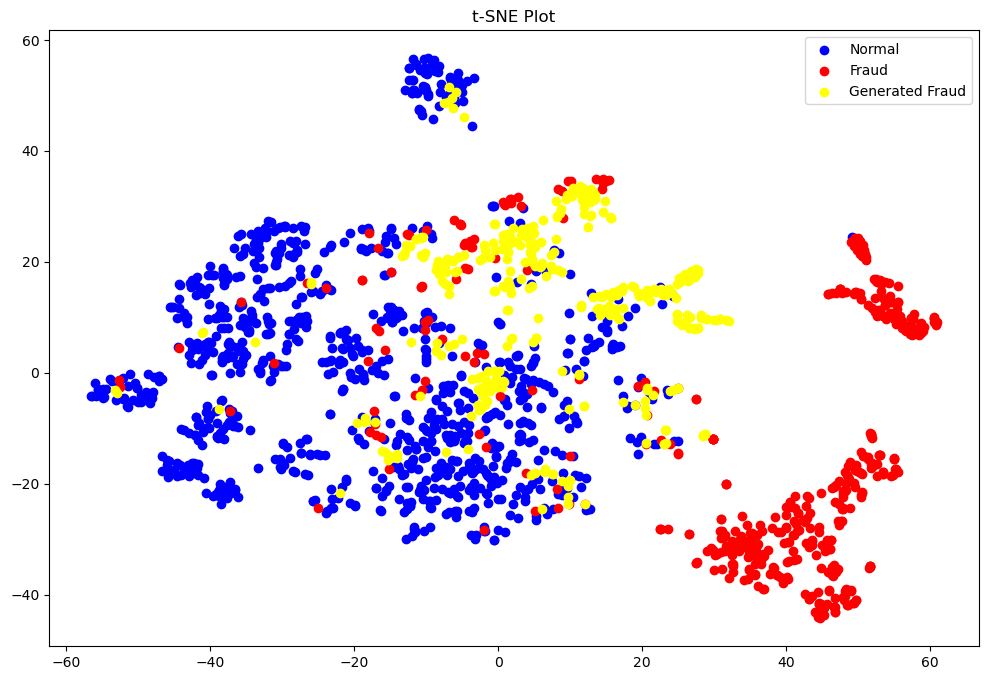

In [58]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.scatter(x=xtsne[np.where(y==2), 0], y=xtsne[np.where(y==2), 1], color="yellow", label='Generated Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()